# General moment calculation for a two- and three-state promoter.

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [240]:
import dill # Library that we will use to export lambdify functions

import numpy as np
# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

tmpdir = '../../tmp/'

# $\LaTeX$ macros
$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## General calculation of the moments of the distribution.

In order to approximate the entire mRNA and protein distribution $P(m, p)$ we use the maximum entropy approach in which moments $\ee{m^x p^y}$ with $x, y \in \mathbb{Z}$ are used to approximate the distribution as
$$
\hat{P}(m, p) = {e^{\sum_{j} \beta_j m^{x_j} p^{y_j}} \over \mathcal{Z}},
$$
where $\beta_j$ is the Lagrange multiplier associated with the $\th{j}$ constraint of the form $\ee{m^{x_j} p^{y_j}}$, and $\mathcal{Z}$ is the partition funciton defined as
$$
\mathcal{Z} = \sum_m \sum_p e^{\sum_{j} \beta_j m^{x_j} p^{y_j}}.
$$

In particular for our system the master equation that describes the time evolution of the distribution is defined by either two or three differential equations, one for each state of the promoter such that
$$
P(m, p) = \sum_{s\in \text{states}} P_s(m, p),
$$
where $s \in \{E, P, R\}$ defines the state $E =$ empty state, $P =$ RNAP bound, and $R =$ repressor bound. The third state is only include in the case where there is transcription factor present. Without loss of generality let's focus here on the three-state promoter. Let $\bb{P}(m, p) = (P_E(m, p), P_P(m, p), P_R(m, p))$ be the vector containing all distributions. Using this notation the system of PDEs that define the distribution is given by
$$
\dt{\bb{P}(m, p)} = \overbrace{
\left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right) \bb{P}(m, p)
}^{\text{exit state }m,p}\\
\overbrace{
+ \Rm \bb{P}(m-1, p) + \Gm (m + 1) \bb{P}(m+1, p)\\
+ \Rp (m) \bb{P}(m, p-1) + \Gm (p + 1) \bb{P}(m, p+1)
}^{\text{enter state }m,p},
\label{master_matrix}
$$
where $\Km$ is the matrix defining transition rates between states, $\Rm$ and $\Gm$ are the matrices defining the production and degradation rates of mRNA respectively, and $\Rp$ and $\Gp$ are the equivalent matrices for the production and degradation of protein.

Given this birth-death process with three different states of the promoter if we want to compute a moment $\ee{m^x p^y}$ we would actually compute
$$
\ee{m^x p^y} = \ee{m^x p^y}_E + \ee{m^x p^y}_P + \ee{m^x p^y}_R,
$$
i.e. the moment at each of the states of the promoter. Let 
$\bb{\ee{m^x p^y}} = \left(\ee{m^x p^y}_E, \ee{m^x p^y}_P, \ee{m^x p^y}_R\right)$ be a vector containing all three moments. The moment PDE is then given by
$$
\dt{\bb{\ee{m^x p^y}}} = \sum_m \sum_p \dt{\bb{P}(m,p)}.
$$

This is computed using Eq. \ref{master_matrix} obtaining
$$
\dt{\bb{\ee{m^x p^y}}} = 
\sum_m \sum_p \left(\Km - \Rm - m\Gm - m\Rp -p\Gp \right)m^x p^y \bb{P}(m, p)\\
\overbrace{
+ \Rm \sum_m \sum_p m^x p^y \bb{P}(m-1, p) 
}^{1}
\overbrace{
+ \Gm \sum_m \sum_p (m + 1) m^x p^y \bb{P}(m+1, p)
}^{2}\\
\overbrace{
+ \Rp \sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) 
}^{3}
\overbrace{
+ \Gm \sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1)
}^{4}.
\label{master_moment_sum}
$$
Each of the numbered terms have stereotypical "tricks" to simplify them. Let's list them (derivation left elsewhere):
$$
1: m' \equiv m - 1\\
\Rightarrow
\sum_m \sum_p m^x p^y \bb{P}(m-1, p) = 
\sum_{m'} \sum_p (m' + 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{(m+1)^x p^y}},
$$
$$
2: m' \equiv m + 1\\
\Rightarrow
\sum_m \sum_p (m + 1) m^x p^y \bb{P}(m + 1, p) = 
\sum_{m'} \sum_p m' (m' - 1)^x p^y \bb{P}(m', p) = \\
\bb{\ee{m (m - 1)^x p^y}},
$$
$$
3: p' \equiv p - 1\\
\Rightarrow
\sum_m \sum_p (m) m^x p^y \bb{P}(m, p-1) =
\sum_m \sum_{p'} m^{x + 1} (p' + 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^{x + 1} (p +  1)^{y}}},
$$
$$
4: p' \equiv p + 1\\
\Rightarrow
\sum_m \sum_p (p + 1) m^x p^y \bb{P}(m, p+1) =
\sum_m \sum_{p'} p' m^x (p' - 1)^y \bb{P}(m, p') = \\
\bb{\ee{m^x p (p - 1)^y}}.
$$

Given these tricks and Eq. \ref{master_moment_sum} we can write a **general** form for the moment PDE given by
$$
\dt{\bb{\ee{m^x p^y}}} =
\Km \bb{\ee{m^x p^y}} +\\
\Rm \left[ \bb{\ee{(m+1)^x p^y}} - \bb{\ee{m^x p^y}} \right] +\\
\Gm \left[ \bb{\ee{m (m - 1)^x p^y}} - \bb{\ee{m^{x + 1} p^y}} \right] +\\
\Rp \left[ \bb{\ee{m^{x + 1} (p +  1)^{y}}} - \bb{\ee{m^{x+1} p^y}} \right] +\\
\Gp \left[ \bb{\ee{m^x p (p - 1)^y}} - \bb{\ee{m^x p^{y+1}}} \right]
\label{master_moment}
$$

## Using `sympy` to compute moments

The objective of this notebook is to use `sympy` in order to set \ref{master_moment} to steady state and solve the equation for the desired moment $\bb{\ee{m^x p^y}}$. This is going to be a function of all moments $\bb{\ee{m^{x'} p^{y'}}}$ with $x' + y' \leq x + y$. For example for the protein second moment $\bb{\ee{p^2}}$ we would need to know
$$
\bb{\ee{p^2}} = f\left(\bb{\ee{m^0 p^0}}, \bb{\ee{m^1 p^0}}, \bb{\ee{m^2 p^0}},
\bb{\ee{m^0 p^1}}, \bb{\ee{m^1 p^1}}\right).
$$

So all we have to do to compute the $\bb{\ee{m^x p^y}}$ moment is to solve for all the moments that satisfy the $x' + y' \leq x + y$ condition before. It is not as good as an MGF, but it is an effective method of getting at these moments.

### Define general moment equation.

Let's define the `sympy` variables that we will need for Eq. \ref{master_moment}.

In [2]:
# Define the matrices involved in the general moment equation
Km = sympy.Symbol('{\mathbf{K}}')  # State transition matrix
Rm, Gm = sympy.symbols('{\mathbf{R}_m} {\mathbf{\Gamma}_m}')  # mRNA matrices
Rp, Gp = sympy.symbols('{\mathbf{R}_p} {\mathbf{\Gamma}_p}')  # protein matrices

Km, Rm, Gm, Rp, Gp

In [218]:
# Define the mRNA and protein variables
m, p, = sympy.symbols('{\mathbf{m}} {\mathbf{p}}')
x, y = sympy.symbols('{\mathbf{x}} {\mathbf{y}}')

m**x, p**y

Let's now define the right hand side of Eq. \ref{master_moment}.

In [4]:
# Defining the general master moment equation
master_moment = Km * (m**x * p**y) +\
Rm * (p**y) * ((m + 1)**x - m**x) +\
Gm * (m * p**y) * ((m - 1)**x - m**x) +\
Rp * m**(x + 1) * ((p + 1)**y - p**y) +\
Gp * (m**x * p) * ((p - 1)**y - p**y)

sympy.Eq(0, master_moment)

Having defined this equation now all we need to do to obtain any moment equation is to substitute $\bb{x}$ and $\bb{y}$. As a sanity check let's look at some examples that we already know the answer. Let's look at the first mRNA moment.

In [5]:
# Define the first mRNA moment <m> equation
master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

The term with $\Rm$ only is actually $\Rm \bb{m}^0$ which is exactly what one obtains when solving for this particular moment.

Let's look now at the second protein moment.

In [6]:
master_moment.subs([[x, 0], [y, 2]]).factor([m, p])

This is again the answer one gets performing the calculation specifically for this moment.

### Extract coefficients of moment polynomial equation.

Let's now define a function that given an expression for a moment it returns a dictionary with all the coefficients of each of the elements in the equation. For example for the previous example of the second protein moment it should return something of the form
$$
\{
\bb{p}^2 : (\Km - 2\Gm), \;\;
\bb{p} : \Gp, \;\;
\bb{mp} : 2\Rp, \;\;
\bb{m} : \Rp
\}
$$

This will be useful for when we substitute the matrices and vectors to solve the linear system.

In [93]:
def coeff_dictionary(eq):
    '''
    Returns a dictionary with each of the coefficients for a given eqent
    equation.

    Parameter
    ---------
    eq : sympy expression.
        Sympy expression for the eqent equation

    Returns
    -------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients of each of the elements
        in the polynomial eqent equation
    '''
    # Find the degree of the eqent for each of the variables
    if eq.has(m):
        m_degree = sympy.Poly(eq).degree(m)
    else:
        m_degree = 0
    if eq.has(p):
        p_degree = sympy.Poly(eq).degree(p)
    else:
        p_degree = 0
    
    return {m**x * p**y: eq.coeff(m**x * p**y).\
            subs([[m, 0], [p, 0]])
            for x in range(m_degree + 1)
            for y in range(p_degree + 1)}

Let's test the function.

In [94]:
p2_dict = coeff_dictionary(master_moment.subs([[x, 0], [y, 2]]).factor([m, p]))
p2_dict

### Build system of equations

From the dictionary of coefficients we can build the augmented matrix that `sympy` uses to solve linear systems. All we need is to define the matrices $\Km$, $\Rm$, $\Gm$, $\Rp$, and $\Gp$ in terms of their components and vectors for each of the moments.

Let's first define the variables that go into the matrices.

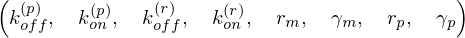

In [87]:
# Define rate constant variables
kp_off, kp_on = sympy.symbols('{k_{off}^{(p)}} {k_{on}^{(p)}}')
kr_off, kr_on = sympy.symbols('{k_{off}^{(r)}} {k_{on}^{(r)}}')

# Define degradation rate and production rate
rm, gm = sympy.symbols('r_m gamma_m')
rp, gp = sympy.symbols('r_p gamma_p')

kp_off, kp_on, kr_off, kr_on, rm, gm, rp, gp

Now let's define a function that given a list of states and a moment of the form $\bb{m^x p^y}$ (as the keys from the dictionary that contains the equation coefficients) it generates an array with the individual moments. For example if the function receives $\bb{m^2 p}$ with three states $\{E, P, R \}$ it returns sympy variables of the form
$$
\ee{m^2 p}_E, \ee{m^2 p}_P, \ee{m^2 p}_R
$$

In [23]:
# Define non-bold variables for m and p
mm, pp = sympy.symbols('m p')
mm, pp

In [96]:
def moment_dict(moments, states=['E', 'P', 'R']):
    '''
    Function that generates automatically sympy variables for a given moment
    one for each of the specified states.
    
    Parameters
    ----------
    moments : list.
        List of sympy variables of the form m**x * p**y for which to 
        generate the moment variables.
    states : array-like.
        List containing strings that define each of the states for which
        to define the moment variables.
        
    Returns
    -------
    moments_dict : dictionary.
        dictionary containing all new defined variables associated with each
        moment.
    '''
    # Initialize dictionary to save the variables
    moments_dict = dict()
    
    # Loop through each of the moments adding the variables to the dictionary
    for mom in moments:
        # Process non-zero moments
        if mom != 1:
            # Find the degree of the moment for each of the variables
            if mom.has(m):
                m_degree = sympy.Poly(mom).degree(m)
            else:
                m_degree = 0
            if mom.has(p):
                p_degree = sympy.Poly(mom).degree(p)
            else:
                p_degree = 0

            # Initialize list to save variables
            mom_var = list()

            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle ' +
                               sympy.latex(mm**m_degree * pp**p_degree) +
                                            '\\rangle}_' + s))
        else:
            # Initialize list to save variables
            mom_var = list()
            
            # Loop through states to generate the variables
            for s in states:
                mom_var.append(sympy.Symbol('{\\langle m^0 p^0' +
                                            '\\rangle}_' + s))
        # Append variables to dictionary
        moments_dict[mom] = mom_var
        
    return moments_dict

Let's generate a dictionary for the variables in the protein second moment dictionary we saved earlier.

In [97]:
# Extract keys from the p2_dict
p2_keys = [key for key, val in p2_dict.items()]

# Generate dictionary with variables for each variable in dictionary
p2_var_dict = moment_dict(p2_keys)

p2_var_dict

#### Testing system with unregulated promoter.

We now have everything in place to try to solve for moments. As an example case let's try to find the first mRNA moment for the **unregualted promoter**. For this we need first to define the matrices for this case.

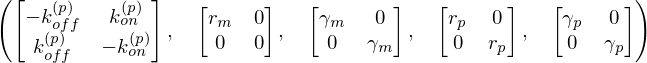

In [88]:
# Define the rate constant matrix
Km_unreg = sympy.Matrix([[-kp_off, kp_on], 
                           [kp_off, -kp_on]])
# Define the mRNA production matrix
Rm_unreg = sympy.Matrix([[rm, 0], 
                         [0, 0]])
# Define the mRNA degradation matrix
Gm_unreg = sympy.Matrix([[gm, 0],
                         [0, gm]])

# Define the protein production matrix
Rp_unreg = sympy.Matrix([[rp, 0], 
                         [0, rp]])
# Define the protein degradation matrix
Gp_unreg = sympy.Matrix([[gp, 0],
                         [0, gp]])


Km_unreg, Rm_unreg, Gm_unreg, Rp_unreg, Gp_unreg

Now let's find the general equation for this first moment.

In [291]:
# Find the equation for the first moment.
m1_eq = master_moment.subs([[x, 1], [y, 0]]).factor([m, p])

sympy.Eq(0, m1_eq)

Next we extract the coefficients of this equation.

In [292]:
# Extract coefficients from equation
m1_coeff_dict = coeff_dictionary(m1_eq)

m1_coeff_dict

Now we define the moment variables for this system

In [293]:
# Extract keys from dictionary
m1_keys = [key for key, value in m1_coeff_dict.items()]

# Generate variables for each of the moments
m1_var_dict = moment_dict(m1_keys, states=['E', 'P'])

m1_var_dict

We now define the augmented matrix to solve the linear system.

**NOTE:** on `sympy` getting to substitute a term like $(\Km - \Gm)$ with the corresponding matrices and then actually doing the subtraction is very convoluted. If you want to reproduce this make sure you follow the instructions.

First to simplify things let's generate a dictionary that instead of having the coefficients as `m1_coeff_dict` it has the substituted matrices.

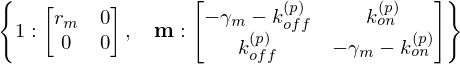

In [294]:
# Initialize dictionary to save the matrices
m1_mat_dict = dict()


tmp_list = list()
# Loop through each of the coefficients and compute the operation
# NOTE: It is quite tricky to get it to work on sympy
for key, value in m1_coeff_dict.items():
    # Check if the coefficient is a single term. If so, just substitute
    # the corresponding matrix
    if len(value.args) == 0:
        m1_mat_dict[key] = value.subs([[Km, Km_unreg],
                                [Rm, Rm_unreg],
                                [Gm, Gm_unreg],
                                [Rp, Rp_unreg],
                                [Gp, Gp_unreg]])
    
        
    # Otherwise make a list of each of the terms in the coefficient 
    # substituting them with their corresponding matrices. 
    else:
        term_list = [x.subs([[Km, Km_unreg],
                             [Rm, Rm_unreg],
                             [Gm, Gm_unreg],
                             [Rp, Rp_unreg],
                             [Gp, Gp_unreg]]) for x in value.args]
    
        # Perform a second round of checking. Elements that have for example
        # Number * Matrix are not explicitly multiplied. For this we will use
        # np.prod by splitting the terms again into its arguments and
        # multiplying the the arguments
        for i, term in enumerate(term_list):
            if len(term.args) == 2:
                term_list[i] = np.prod(term.args)
    
        # Add the matrices. In order to do so:
        # the sum function has an optional "start" argument so you can initialize 
        # it with a "zero object" of the kind you are adding. 
        # In this case, with a zero matrix.
        m1_mat_dict[key] = sum(term_list, sympy.zeros(*Km_unreg.shape))

m1_mat_dict

After that